Aproximación directa del problema, vamos a suponer una solución

$$ y = a_0 + a_1 x_{t} + a_2 x_{t-1} + \dots + a_{m+1} x_{t-m}$$

Donde m es el tamaño de la ventana temporal, número de pasos anteriores que vamos a usar.

La aproximación la haremos a un paso, es decir $y = x_{t+1}$. Con la misma filosofía se podria asumir que $y = x_{t+n}$ si queremos hacer una aproximacion a n pasos.

EL error que usaremos será el cuádratico medio. Teniendo en cuenta que los datos tienen que estar normalizados, la función de coste sería:

$$ C_P = (1 - < y , h(x) >)^2 $$

Donde h_(x) es la predicción a un paso. Estamos basándonos en la implementación de Quiskit de una circuito variacional que halla polinomios [1](https://learn.qiskit.org/course/ch-demos/variational-quantum-regression)

La optimización se realizará por descenso del gradiente estocástico. La derivada parcial repecto a los pesos son:

$$ \dfrac{\partial C_P}{ \partial a_0} = 2(1 - <y,1>) $$
$$ \dfrac{\partial C_P}{ \partial a_i} = 2(1 - <y,h(x)>) <y , x_{t-i-1}> $$

Luego la actualización de los pesos sería:

$$ \begin{pmatrix} a_0^{i+1} \\ a_1^{i+1} \\ \vdots \\a_{m+1}^{i+1} \end{pmatrix} = 
    \begin{pmatrix} a_0^{i} \\ a_1^{i} \\ \vdots \\a_{m+1}^{i} \end{pmatrix} - 
    \eta \dfrac{2}{M}\sum_{j=1}^M \begin{pmatrix} (1 - <y_j,1>) \\ (1 - <y_j,h(x_j)>) <y_j , x_{j,t-i-1}> \\ \vdots \\ (1 - <y_j,h(x_j)>) <y_j , x_{j,t-m}>\end{pmatrix}
$$

Donde M es el tamaño del Batch, el cálculo del producto escalar lo haremos en un computador cuántico

In [1]:
# Para manejo de datos Clásicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime

# Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random

#Minimize
from scipy.optimize import minimize


Procesemos todos los datos, se pondra directamente todo, en otro Note book se ve paso por paso

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

# Crear los conjuntos
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

tiempo = data_shift.drop(['#Passengers'], axis=1)
tiempo_train = tiempo.head(int(pasajeros.shape[0]*0.8))
tiempo_test = tiempo.tail(pasajeros.shape[0] - int(pasajeros.shape[0]*0.8))

# Pasemos a numpy
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window
conjunto_train = []
objetivo_train = []
conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])

for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])
    
objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

Función que calcula el producto interno entre dos vectores, en particular elementos

In [3]:
len(objetivo_train)

102

In [4]:
nqubits = math.ceil(np.log2(len(conjunto_train)))
def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1,1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    if(len(vec) != 2**(nqubits+1)):
        vec = np.concatenate((vec,np.zeros(2**(nqubits+1) - len(vec))))
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=20000)

    result = job.result()
    outputstate = result.get_counts(circ)

    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/20000
    else:
        m_sum = 0
     
    return 2*m_sum-1

Cambio de paradigma, VAMOS a usar el error cuadrático medio normal, necesitamos calcular el producto escalar entre a y X

In [5]:
np.linalg.norm(objetivo_train)

1.0672959652570082

In [6]:
objetivo_train

array([ 0.09134978,  0.11247798, -0.04348511, -0.07696104,  0.17563257,
        0.13185213,  0.        , -0.0732034 , -0.1722459 , -0.15415068,
        0.20544397,  0.03509132,  0.03390155,  0.17114826, -0.08803335,
        0.05374428,  0.03428907,  0.11152127,  0.        , -0.07836907,
       -0.12733942, -0.10398971,  0.12838117,  0.02967577,  0.05129329,
        0.06973334, -0.06419316,  0.01098912,  0.17500891,  0.05358425,
        0.05085842, -0.14660347, -0.09006082, -0.10477895,  0.12036368,
        0.0102565 ,  0.        ,  0.18571715, -0.00424629, -0.02586351,
        0.05933944,  0.08288766,  0.02985296, -0.13774193, -0.11620201,
       -0.15890128,  0.11034806,  0.01481509, -0.08167803,  0.22314355,
       -0.0346355 ,  0.0303711 ,  0.12062799,  0.13447791, -0.03025441,
       -0.12334455, -0.12310606, -0.12051602,  0.12051602,  0.05521572,
       -0.03789927,  0.1362102 ,  0.00746272,  0.00371058,  0.15415068,
        0.14458123, -0.04782909, -0.10632159, -0.12987508, -0.14

In [7]:
def calculate_cost_function(parameters):
        
    ansatzNorm = np.linalg.norm(parameters)     # normalise ansatz
    ansatz = parameters/ansatzNorm
    ynorm = np.linalg.norm(objetivo_train)
    coste=0
    for i in range(len(objetivo_train)):
        x = np.insert(conjunto_train[i], 0, 1)
        norm_x = np.linalg.norm(x)
        produtcto = ansatzNorm*norm_x*inner_prod(x/norm_x,ansatz)
        coste = coste + (objetivo_train[i] - produtcto)**2
        
    return coste

In [8]:
# Entrenamiento
x0 = np.ones(window+1)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)

params = out1['x']
params

array([2.07950166, 0.73678263, 2.04810009, 1.39296296, 0.92194976,
       0.89756793, 0.85215135, 0.97408557, 0.90622995, 0.95213453,
       0.8666094 , 0.87517975, 2.24308521])

In [9]:
out1

     fun: 1.2280389505386988
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 148
  status: 1
 success: True
       x: array([2.07950166, 0.73678263, 2.04810009, 1.39296296, 0.92194976,
       0.89756793, 0.85215135, 0.97408557, 0.90622995, 0.95213453,
       0.8666094 , 0.87517975, 2.24308521])

In [99]:
# Segunda normalización ya clásica...
def calculate_cost_function2(params1):
    coste = 0
    for i in range(len(conjunto_train)):
        coste = coste + ( objetivo_train[i] - params1[0] - params1[1]*np.insert(conjunto_train[i] ,0,1) @ params.T )**2

    return coste

In [100]:
np.sum( objetivo_train**2 )

1.1391206774538885

In [101]:
# Entrenamiento
x0 = [0.5,0.5]
out2 = minimize(calculate_cost_function2, x0=x0, method="L-BFGS-B", options={'maxiter':20000}, tol=1e-6)

params_nor = out2['x']
params_nor

array([-0.08521077,  0.0445967 ])

In [102]:
y_ = []
for i in range(len(conjunto_train)):
    y_.append(np.insert(conjunto_train[i] ,0,1) @ params.T)
y_ = params_nor[0] + params_nor[1]*np.array(y_)
espacio = np.arange(len(conjunto_train))

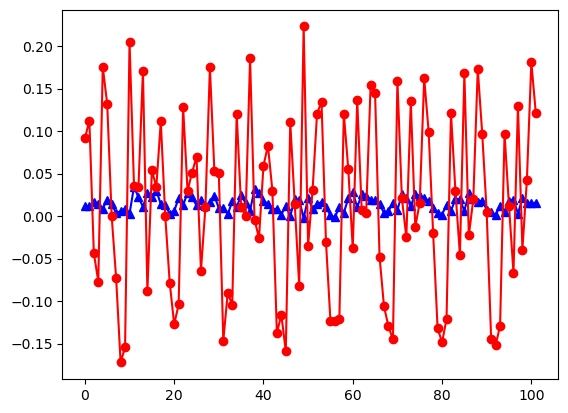

In [103]:
plt.plot(espacio, y_, marker='^', color='blue')
plt.plot(espacio, objetivo_train, marker='o', color='red')
plt.show()

In [104]:
calculate_cost_function2([-0.08521077,  0.0445967 ])

1.1116713664169273

In [105]:
calculate_cost_function2([-0.08521077,  0.0445967*2 ])

2.1270987591991757